<a href="https://colab.research.google.com/github/Mgrinet/classificacao-digitos-MNIST/blob/master/classifica%C3%A7%C3%A3o_digitos_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Digitos - MNIST


## Configuração

Primeiro, vamos garantir que este notebook funcione bem tanto no python 2 quanto no 3, importe alguns módulos comuns, garanta que o MatplotLib plote figuras em linha e prepare uma função para salvar os números:

In [0]:
# Para funcionar tanto no python 2 quanto no python 3
from __future__ import division, print_function, unicode_literals

# Importar bibliotecas
import numpy as np
import os

# Estabilizar aleatoriedade do notebook
np.random.seed(42)

# plotar os graficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## MNIST

Neste capítulo, usaremos o conjunto de dados MNIST, que é um conjunto de 70.000
imagens de dígitos manuscritas por alunos do ensino médio e funcionários do Censo dos EUA. Cada imagem é rotulada com o dígito que representa

O Scikit-Learn fornece muitas funções auxiliares para baixar datasets populares, e o MNIST é um deles. O código a seguir busca o conjunto de dados MNIST:

**Atenção**: `fetch_mldata()` está obsoleto desde o Scikit-Learn 0.20. Você deve usar `fetch_openml()`. No entanto, ele retorna o conjunto de dados MNIST não classificado, enquanto `fetch_mldata()` retornou o conjunto de dados classificado por destino (o conjunto de treinamento e o teste de teste foram classificados separadamente). Em geral, isso é bom, mas se você quiser obter exatamente os mesmos resultados de antes, precisará classificar o conjunto de dados usando a seguinte função:

In [0]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [0]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"], mnist["DESCR"]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([0., 0., 0., ..., 9., 9., 9.]),
 'mldata.org dataset: mnist-original')

Os datasets carregados pelo Scikit-Learn geralmente têm uma estrutura de dicionário semelhante, incluindo:

• Uma chave "DESCR" descrevendo o conjunto de dados

• Uma chave "data" contendo uma matriz com uma linha por instância e uma coluna por característica

• Uma chave "target" contendo uma matriz com os rótulos

In [0]:
mnist.data.shape

(70000, 784)

In [0]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [0]:
y.shape

(70000,)

Existem 70.000 imagens e cada imagem possui 784 features. Isso ocorre porque cada imagem é 28 × 28 pixels, e cada recurso representa apenas a intensidade de um pixel, de 0 (branco) a 255 (preto). Vamos dar uma olhada em um dígito do conjunto de dados. Tudo o que você precisa fazer é pegar o vetor de features de uma instância, reformulá-lo para uma matriz 28 × 28 e exibi-lo usando Função `imshow()` do Matplotlib:

In [0]:
28*28

784

Saving figure some_digit_plot


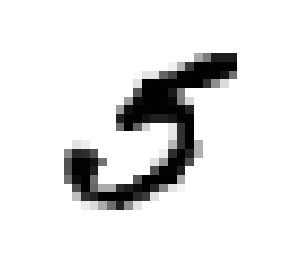

In [0]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()


Isso parece um 5 e, de fato, é isso que o label nos confirma:

In [0]:
y[36000]

5.0

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [0]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Esta figura mostra mais algumas imagens do conjunto de dados MNIST para dar uma ideia da complexidade da tarefa de classificação.

Saving figure more_digits_plot


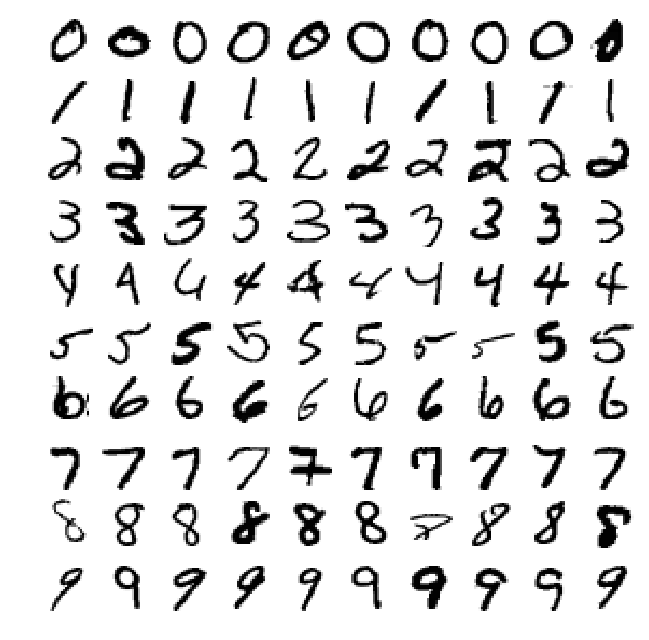

In [0]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

**Lembrando**: Você deve sempre criar um conjunto de testes e colocá-lo de lado antes de inspecionar os dados
de perto. O conjunto de dados MNIST na verdade já está dividido em um conjunto de treinamento (os primeiros 60.000
imagens) e um conjunto de teste (as últimas 10.000 imagens):

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Vamos também embaralhar (shuffle) o conjunto de treinamento; isso garantirá que todas as dobras (folds) de validação cruzada seja semelhante (você não quer que uma dobra fique faltando alguns dígitos). Além disso, alguns algoritmos de aprendizado são sensíveis à ordem das instâncias de treinamento, e eles executam
mal se eles obterem muitos casos semelhantes seguidos. Embaralhar o conjunto de dados garante que isso não aconteça:

In [0]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

**Atenção!** O embaralhamento pode ser uma má ideia em alguns contextos - por exemplo, se você estiver trabalhando em dados de séries temporais (como preços do mercado de ações ou condições climáticas). Vamos explorar isso nas próximas aulas.

## Classificador Binario

Vamos simplificar o problema por enquanto e tentar identificar apenas um dígito - por exemplo, o número 5. Esse "detector de número 5" será um exemplo de um classificador binário, capaz de distinguir entre apenas duas classes, 5 e não-5. Vamos criar os vetores de destino para esta tarefa de classificação:

In [0]:
y_train_5 = (y_train == 5) #Verdadeiro para todos os 5s, Falso para todos os outros dígitos.
y_test_5 = (y_test == 5)

Ok, agora vamos escolher um classificador e treiná-lo. Um bom lugar para começar é com um classificador de gradiente descendente estocástico (SGD), usando a classe SGDClassifier do Scikit-Learn. Esse classificador tem a vantagem de ser capaz de lidar com conjuntos de dados muito grandes de maneira eficiente. Isto é em parte porque o SGD lida com instâncias de treinamento independentemente, uma de cada vez (o que também torna o SGD adequado para o aprendizado online), como veremos mais adiante. Vamos criar um SGDClassifier e treiná-lo em todo o conjunto de treinamento:

**Nota**: Alguns hiperparâmetros terão um valor padrão diferente em versões futuras do Scikit-Learn, portanto, um aviso será emitido se você não os definir explicitamente. É por isso que definimos `max_iter=5` e` tol=-np.infty`, para obter os mesmos resultados que no livro, evitando os avisos.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=-inf, verbose=0, warm_start=False)

Agora vamos usá-lo para detectar imagens do número 5:

In [0]:
sgd_clf.predict([some_digit])

array([ True])

O classificador adivinha que essa imagem representa um 5 (True). Agora, vamos avaliar o desempenho desse modelo.

## Medidas de Desempenho

Avaliar um classificador é bem mais complicado do que avaliar um regressor, então vamos dar uma olhada nas varias medidas de desempenho disponíveis!


**Medindo Precisão Usando Validação Cruzada (Cross-Validation)**

Uma boa maneira de avaliar um modelo é usar validação cruzada

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

As vezes, você precisa de mais controle sobre o processo de validação cruzada do que o que `cross_val_score()` e funções similares fornecem. Nesses casos, você pode implementar a validação cruzada por conta própria; Na verdade, é bastante simples. O código a seguir faz basicamente o mesmo que o código `cross_val_score()` anterior e imprime o mesmo resultado:

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

A classe StratifiedKFold realiza amostragem estratificada para produzir dobras (folds) que contêm uma proporção representativa de cada classe. Em cada iteração, o código cria um clone do classificador, treina os clones nas dobras de treinamento e faz previsões na dobra de teste. Em seguida, conta o número de previsões corretas e gera a proporção de previsões corretas.

In [0]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Vamos usar a função `cross_val_score()` para avaliar o modelo SGDClassifier usando validação cruzada de K-fold com três dobras. Lembrando que a validação cruzada K-fold significa dividir o conjunto de treinamento em K dobras (neste caso, três), depois fazer previsões e avaliá-las em cada dobra, usando um modelo treinado nas dobras restantes:

In [0]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

Acima de 95% de acurácia (razão de previsões corretas) em todas as dobras de validação cruzada. Isso parece muito bom, mas antes de ficar muito animado, vamos ver porque um classificador que aparenta ser muito bom pode, na verdade, não ser tão bom assim...

Isto é simplesmente porque apenas 10% das imagens são 5s, então se você sempre acha que uma imagem não é 5, você estará certo em 90% do tempo.

**Resumindo**: Uma classificação binária em uma configuração desproporcional pode causar resultados enganosos.

Isso demonstra por que a precisão geralmente não é a medida de desempenho preferencial para os classificadores, especialmente quando você está lidando com datasets distorcidos (skewed) (ou seja, quando algumas classes são muito mais frequentes do que outras).

## Matriz de Confusão

Uma maneira muito melhor de avaliar o desempenho de um classificador é observar a matriz de confusão. A ideia geral é contar o número de vezes que as instâncias da classe A são classificadas como classe B. Por exemplo, para saber o número de vezes que o classificador confundiu imagens de 5s com 3s, você procuraria na quinta linha e na terceira coluna do matriz de confusão.
Para calcular a matriz de confusão, primeiro você precisa ter um conjunto de previsões, para que elas possam ser comparadas com os alvos reais. Você pode fazer previsões no conjunto de testes, mas vamos mantê-lo intocado por enquanto (lembrando que sempre queremos usar o conjunto de testes apenas no final do projeto, depois de ter um classificador pronto para ser iniciado).

Em vez disso, você pode usar a função `cross_val_predict()`:

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Assim como a função `cross_val_score()`, `cross_val_predict()` executa a validação cruzada de K-fold, mas, em vez de retornar as pontuações de avaliação, retorna as previsões feitas em cada dobra de teste. Isso significa que você obtém uma previsão limpa para cada instância no conjunto de treinamento (“limpa”, significando que a previsão é feita por um modelo que nunca viu os dados durante o treinamento).

Cada linha em uma matriz de confusão representa uma classe real, enquanto cada coluna representa uma classe prevista. 

A primeira linha desta matriz considera imagens "não-5" (a classe negativa): 53.272 delas foram corretamente classificadas como "não-5" (elas são chamadas de verdadeiros negativos), enquanto as 1.307 restantes foram erroneamente classificadas como 5s (falsos positivos). 

A segunda linha considera as imagens de 5s (a classe positiva): 1.077 foram erroneamente classificados como "não-5s" (falsos negativos), enquanto os restantes 4.344 foram classificados corretamente como 5s (positivos verdadeiros). 

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

Um classificador perfeito teria apenas verdadeiros positivos e verdadeiros negativos, portanto, sua matriz de confusão teria valores diferentes de zero apenas em sua diagonal principal (parte superior esquerda para a parte inferior direita):

In [0]:
y_train_perfect_predictions = y_train_5

In [0]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

A matriz de confusão fornece muitas informações, mas às vezes você pode preferir uma métrica mais concisa. Uma métrica interessante é olhar para a precisão das previsões positivas; isso é chamado a precisão do classificador:


## Precisão e Recall
Precisão = TP/(TP+FP)

Onde:
TP é o número de positivos verdadeiros, e FP é o número de falsos positivos.

Uma maneira facil de obter precisão perfeita é fazer uma única previsão positiva e garantir que esteja correta (precisão = 1/1 = 100%). Isso não seria muito útil, pois o classificador ignoraria todas, exceto uma instância positiva. Então precisão é tipicamente usada junto com outra métrica chamada recall, também chamada de sensibilidade ou taxa positiva verdadeira (TPR).

(TPR): esta é a proporção de instâncias positivas que são corretamente detectadas pelo classificador

Recall = TP/(TP+FN)

Onde: FN é, obviamente, o número de falsos negativos.


O Scikit-Learn fornece várias funções para calcular as métricas do classificador, incluindo precisão e recall:


In [0]:
from sklearn.metrics import precision_score, recall_score

print('precisão', precision_score(y_train_5, y_train_pred))

print('recall:', recall_score(y_train_5, y_train_pred))

precisão 0.7687135020350381
recall: 0.801328168234643


Agora o seu "detector de número 5" não parece tão bom como quando você olhou para a sua precisão. Quando o modelo afirma que uma imagem representa um 5, ela está correta apenas ~77% do tempo. Além disso, detecta apenas ~80% dos 5s.

Geralmente é conveniente combinar precisão e recall em uma única métrica chamada pontuação F1, em particular se você precisar de uma maneira simples de comparar dois classificadores. A pontuação F1 é a média harmônica de precisão e recordação.

F1 = 2* (precisão*recall)/(precisão+recall) = TP/(TP+((FN+FP)/2))

Enquanto a média regular trata todos os valores igualmente, a média harmônica atribui muito mais peso a valores baixos. Como resultado, o classificador só obterá uma pontuação alta na F1 se tanto a recordação quanto a precisão forem altas.

**Resumindo**: A média harmônica penaliza mais os valores menores.

Para calcular a pontuação F1, simplesmente chame a função `f1_score()`:

In [0]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [0]:
4344 / (4344 + (1077 + 1307)/2)

0.7846820809248555

A pontuação de F1 favorece os classificadores que têm precisão e recall semelhantes. 

Isso nem sempre é o que você quer: em alguns contextos você se preocupa principalmente com a precisão e em outros contextos que realmente se preocupam com o recall. 

Por exemplo, se você treinou um classificador para detectar vídeos seguros para crianças, provavelmente preferiria um classificador que rejeita muitos vídeos bons (baixo recall), mas mantém apenas os seguros (alta precisão), em vez de um classificador que tem muito maior recall, mas permite que alguns vídeos realmente ruins apareçam em seu produto (nesses casos, você pode até querer adicionar um pipeline humano para verificar a seleção de vídeo do classificador). 

Por outro lado, suponha que você treine um classificador para detectar ladrões de lojas em imagens de vigilância: provavelmente é bom se seu classificador tiver apenas 30% de precisão, desde que tenha 99% de recall (claro, os seguranças receberão alguns alertas falsos, mas quase todos os ladrões serão pegos).

Infelizmente, você não pode ter as duas coisas: o aumento da precisão reduz o recall e vice-versa. Isso é chamado de tradeoff de precisão / recall.

## Precisão / Recall Tradeoff

Para entender essa desvantagem, vamos ver como o `SGDClassifier` toma suas decisões de classificação. 

Para cada instância, ele calcula uma pontuação com base em uma função de decisão e, se essa pontuação for maior que um limite, atribui a instância à classe positiva ou a atribui à classe negativa. 

O Scikit-Learn não permite definir o limite diretamente, mas fornece acesso às pontuações de decisão usadas para fazer previsões. Em vez de chamar o método `predict()` do classificador, você pode chamar o método `decision_function()`, que retorna uma pontuação para cada instância e, em seguida, fazer previsões com base nessas pontuações usando qualquer limite desejado:


In [0]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [0]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [0]:
y_some_digit_pred

array([ True])

O `SGDClassifier` usa um limite igual a 0, portanto, o código anterior retorna o mesmo resultado que o método `predict()` (ou seja, True). Vamos aumentar o limite:

In [0]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Isso confirma que aumentar o limite diminui a recuperação. A imagem realmente representa um 5, e o classificador detecta quando o limiar é 0, mas erra quando o limite é aumentado para 200.000. 

Então, como você pode decidir qual limite usar? Para isso, primeiro você precisa obter as pontuações de todas as instâncias no conjunto de treinamento usando a função `cross_val_predict()` novamente, mas desta vez especificando que deseja retornar os escores de decisão em vez das previsões:

In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Agora, com essas pontuações, você pode calcular a precisão e o recall para todos os possíveis limites usando a função `precision_recall_curve()`:

**Nota**: houve um [problema] (https://github.com/scikit-learn/scikit-learn/issues/9589) no Scikit-Learn 0.19.0 (corrigido em 0.19.1) onde o resultado de `cross_val_predict() `estava incorreto no caso de classificação binária ao usar`method="decision_function"`, como no código acima. O array resultante tinha uma primeira dimensão extra cheia de 0s. Apenas no caso de você estar usando 0.19.0, precisamos adicionar este pequeno hack para contornar esse problema:

In [0]:
y_scores.shape

(60000,)

In [0]:
# hack para resolver o problema #9589 com o Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


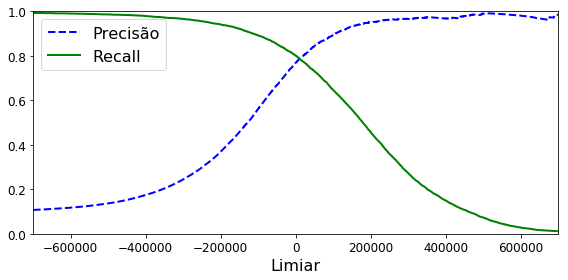

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisão", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Limiar", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

**Explicando o comportamento das curvas**: Por que a curva de precisão é mais irregular do que a curva de recall? 

A razão é que, às vezes, a precisão pode diminuir quando você aumenta o limite (embora, em geral, ele suba). Por outro lado, o recall só pode diminuir quando o limite é aumentado, o que explica por que sua curva parece suave.

Agora você pode simplesmente selecionar o valor limite que lhe dá o melhor tradeoff de precisão / recall para sua tarefa.

In [0]:
(y_train_pred == (y_scores > 0)).all()

True

Outra maneira de selecionar uma boa troca de precisão / recall é plotar a precisão diretamente contra o recall, como mostrado a seguir:

Saving figure precision_vs_recall_plot


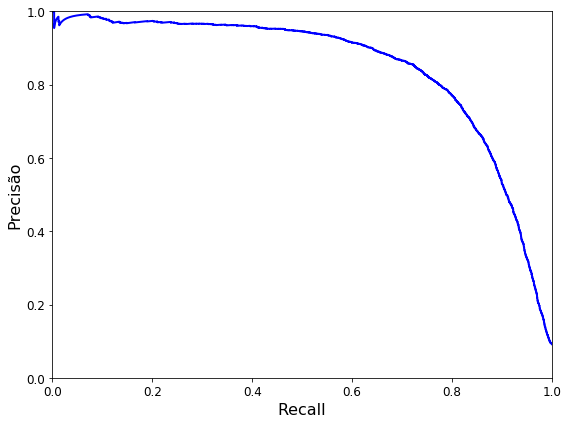

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precisão", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Você pode ver que a precisão realmente começa a cair drasticamente em torno de 80%. Você provavelmente desejará selecionar um tradeoff de precisão / recall logo antes da queda - por exemplo, com cerca de 60% de recall. Mas é claro que a escolha depende do seu projeto. 

Então, suponhamos que você tenha a meta de 90% de precisão. Você procura no primeiro gráfico (ampliando um pouco) e descobre que precisa usar um limite de cerca de 70.000. Para fazer previsões (no conjunto de treinamento, por enquanto), em vez de chamar o método `predict()` do classificador, basta executar este código:

In [0]:
y_train_pred_90 = (y_scores > 70000)

In [0]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [0]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

Ótimo, você tem um classificador de precisão de >85%! Como você pode ver, é bastante fácil criar um classificador com praticamente qualquer precisão desejada: basta definir um limite suficientemente alto e pronto!

**Lembrando**: Um classificador de alta precisão não é muito útil se o seu recall for muito baixo! Se alguém disser "vamos chegar a 99% de precisão", você deve perguntar "a que recall?"

# ROC curves

A curva característica de operação do receptor (ROC) é outra ferramenta comum usada classificadores binários. 

É muito semelhante à curva de precisão / recall, mas em vez de plotar precisão versus recall, a curva ROC traça a taxa positiva verdadeira (outro nome para recall) contra a taxa de falsos positivos (FPR). 

O FPR é a proporção de instâncias negativas que são incorretamente classificadas como positivas. É igual a um menos a taxa real negativa, que é a proporção de instâncias negativas que são corretamente classificadas como negativas (TNR). 

O TNR também é chamado de especificidade. Portanto, a curva ROC plota:

sensibilidade versus (1 - especificidade).

Para plotar a curva ROC, primeiro você precisa calcular o TPR e o FPR para vários valores de limite, usando a função `roc_curve()`:

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


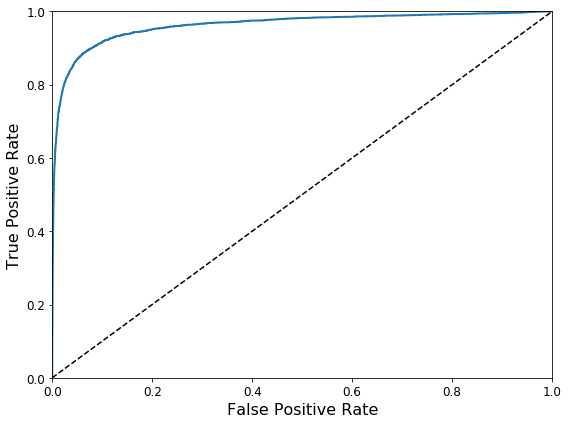

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Mais uma vez, existe um tradeoff: quanto maior o recall (TPR), mais falsos positivos (FPR) o classificador produz. 

A linha pontilhada representa a curva ROC de um classificador puramente aleatório; um bom classificador fica o mais longe possível dessa linha (em direção ao canto superior esquerdo). 

Uma maneira de comparar os classificadores é medir a área sob a curva (AUC). Um classificador perfeito terá uma AUC ROC igual a 1, enquanto um classificador puramente aleatório terá uma AUC ROC igual a 0,5. 

O Scikit-Learn fornece uma função para calcular a AUC do ROC:

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967155

Como a curva ROC é tão semelhante à curva de precisão / recall (ou PR), você pode se perguntar como decidir qual delas usar. 

Como regra geral, você deve preferir a curva PR sempre que a classe positiva for rara ou quando você se importar mais com os falsos positivos do que com os falsos negativos e a curva ROC no caso contrário.

Por exemplo, olhando para a curva ROC anterior (e a pontuação ROC AUC), você pode pensar que o classificador é realmente bom. Mas isso é principalmente porque existem poucos positivos (5s) em comparação com os negativos (não-5s). 

Em contraste, a curva PR deixa claro que o classificador tem espaço para melhorias (a curva pode estar mais próxima do canto superior direito).


Vamos treinar um `RandomForestClassifier` e comparar sua curva ROC e pontuação ROC AUC para o `SGDClassifier`. 

Primeiro, você precisa obter pontuações para cada instância no conjunto de treinamento. Mas devido à maneira como funciona, o classificador `RandomForestClassifier` não possui um método `decision_function()`. 

Em vez disso, ele tem um método pre `dict_proba()`. 

Os classificadores do Scikit-Learn geralmente possuem um ou outro. 

O método `predict_proba()` retorna uma matriz contendo uma linha por instância e uma coluna por classe, cada uma contendo a probabilidade de que a instância determinada pertença à classe determinada (por exemplo, 70% de chance de a imagem representar um 5):

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

**Nota**: nós definimos `n_estimators = 10` para evitar um aviso sobre o fato de que seu valor padrão será ajustado para 100 no Scikit-Learn 0.22.


Mas para plotar uma curva ROC, você precisa de pontuações, não de probabilidades. Uma solução simples é usar a probabilidade da classe positiva como a pontuação:

In [0]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


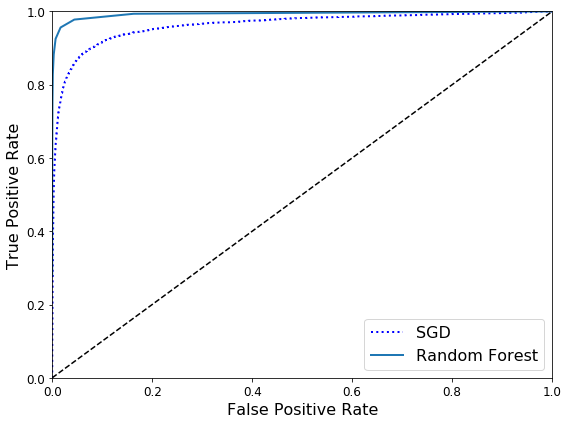

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Como você pode ver, a curva ROC do `RandomForestClassifier` parece muito melhor do que a do `SGDClassifier`: ela fica muito mais próxima do canto superior esquerdo. 

Como resultado, sua pontuação na ROC AUC também é significativamente melhor:

In [0]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [0]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print('precisão:', precision_score(y_train_5, y_train_pred_forest))
print('recall:', recall_score(y_train_5, y_train_pred_forest))

precisão: 0.9852973447443494
recall: 0.8282604685482383


Medindo a precisão e as pontuações de recall: encontramos 98,5% de precisão e 82,8% de recall. 

Com isso, encerramos os classificadores binários!

**Dica**: Sempre que for treinar classificadores binários, escolha a métrica apropriada para sua tarefa, avalie seus classificadores usando validação cruzada, selecione a troca de precisão / recall que atenda às suas necessidades e compare vários modelos usando curvas ROC e pontuações ROC AUC. 


Agora vamos tentar detectar mais do que apenas os 5s com Classificação Multiclasse.

# Classificação Multiclasse

Enquanto os classificadores binários distinguem entre duas classes (0, 1), os classificadores multiclasse (também chamados de classificadores multinomiais) podem distinguir entre mais de duas classes.


Alguns algoritmos (como classificadores Random Forest ou classificadores Naive Bayes) são capazes de lidar com várias classes diretamente. Outros (como classificadores Support Vector Machine ou classificadores lineares) são classificadores estritamente binários. 

No entanto, existem várias estratégias que você pode usar para executar a classificação multiclasse usando vários classificadores binários.

Por exemplo, uma maneira de criar um sistema que possa classificar as imagens digitadas em 10 classes (de 0 a 9) é treinar 10 classificadores binários, um para cada dígito (um detector de 0, um detector de 1, um detector de 2 e assim por diante). 

Então, quando você deseja classificar uma imagem, você obtém a pontuação de decisão de cada classificador para essa imagem e seleciona a classe cujo classificador gera a pontuação mais alta. Isso é chamado de estratégia one-versus-all (OvA) (também chamado de one-versus-rest).

Outra estratégia é treinar um classificador binário para cada par de dígitos: um para distinguir 0s e 1s, outro para distinguir 0s e 2s, outro para 1s e 2s, e assim por diante. Isso é chamado de estratégia de one-versus-one (OvO). 

Se houver classes N, você precisa treinar classificadores N × (N - 1) / 2. 

Para o problema MNIST, isso significa treinar 45 classificadores binários! 

Quando você quer classificar uma imagem, você tem que executar a imagem através de todos os 45 classificadores e ver qual classe vence a maioria dos duelos. 

A principal vantagem do OvO é que cada classificador só precisa ser treinado por parte do conjunto de treinamento para as duas classes que ele deve distinguir.

Alguns algoritmos (como os classificadores Support Vector Machine) têm um escalonamento ruim com o tamanho do dataset, portanto, para esses casos, o OvO é preferido, pois é mais rápido treinar muitos classificadores em datasets pequenos do que treinar poucos classificadores em grandes datasets. 

Para a maioria dos algoritmos de classificação binária, no entanto, o OvA é o preferido. 

O Scikit-Learn detecta quando você tenta usar um algoritmo de classificação binária para uma tarefa de classificação multiclasse e executa automaticamente o OvA (exceto para os classificadores SVM para os quais ele usa o OvO). 

Vamos tentar isso com o `SGDClassifier`:

In [0]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

Esse código treina o `SGDClassifier` no dataset usando as classes de destino originais de 0 a 9 (y_train), em vez das classes de destino 5 versus todas (y_train_5). 

E então faz uma previsão (correta neste caso). No backend, o Scikit-Learn realmente treinou 10 classificadores binários, obteve suas pontuações de decisão para a imagem e selecionou a classe com a maior pontuação. 

Para ver que este é realmente o caso, você pode chamar o método `decision_function()`. 

Em vez de retornar apenas uma pontuação por instância, agora retorna 10 pontuações, uma por turma:

In [0]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

E com isso confirmamos que a classe 5 tem o maior score

In [0]:
np.argmax(some_digit_scores)

5

In [0]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [0]:
sgd_clf.classes_[5]

5.0

**Nota**: Quando um classificador é treinado, ele armazena a lista de classes de destino em seu classes_attribute, ordenada por valor. Nesse caso, o índice de cada classe no classes_array corresponde à classe propriamente dita (por exemplo, a classe no índice 5 passa a ser classe 5), mas em geral isso nem sempre acontece!


Se você quer forçar o ScikitLearn a usar um contra um ou um contra tudo, você pode usar as classes `OneVsOneClassifier` ou `OneVsRestClassifier`. 

Basta criar uma instância e passar um classificador binário para seu construtor. 

Por exemplo, este código cria um classificador multiclasse usando a estratégia OvO, baseada em um `SGDClassifier`:

In [0]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [0]:
len(ovo_clf.estimators_)

45

E treinando um `RandomForestClassifier` da mesma forma:

In [0]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

Desta vez, o Scikit-Learn não precisou executar OvA ou OvO porque os classificadores Random Forest podem classificar diretamente as instâncias em várias classes. 

Você pode chamar `predict_proba()` para obter a lista de probabilidades que o classificador atribuiu a cada instância para cada classe:

In [0]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

Você pode ver que o classificador está bastante confiante em relação à sua previsão: o 0,8 no 5º índice da matriz significa que o modelo estima uma probabilidade de 80% de que a imagem seria um numero 5. Tambem podemos notar um 10% chance da imagem ser classificada como 0 ou 3.

Agora, para avaliar esses classificadores, como de costume, vamos avaliar a precisão do `SGDClassifier` usando a função `cross_val_score()`:

In [0]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

O classificador obtém mais de 84% em todas as dobras de teste. Se você usou um classificador aleatório, você obteria 10% de precisão, então essa não é uma pontuação tão ruim, mas ainda podemos fazer muito melhor. 

Por exemplo, simplesmente escalar as entradas (como discutido na aula anterior) aumenta a precisão acima de 90%, como podemos ver:

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

## Erro de análise

Naturalmente, se este fosse um projeto real, você seguiria as etapas da sua lista de verificação de aprendizado de máquina:

-explorando opções de preparação de dados;

-experimentando vários modelos;

-selecionando os melhores e ajustando seus hiperparâmetros usando `GridSearchCV`;

-automatizando o máximo possível;

Aqui, vamos supor que você encontrou um modelo promissor e deseja encontrar maneiras de melhorá-lo. 

Uma maneira de fazer isso é analisar os tipos de erros cometidos. 

Primeiro, você pode ver a matriz de confusão. Você precisa fazer previsões usando a função `cross_val_predict()` e, em seguida, chamar a função `confusion_matrix()`, assim como fizemos anteriormente:

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

Isso é um monte de números. 

Muitas vezes, é mais conveniente observar uma representação de imagem da matriz de confusão, usando a `função matshow()` do Matplotlib:

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


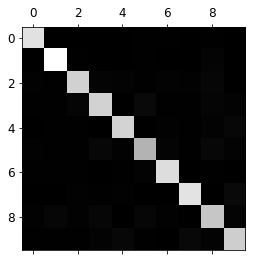

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Essa matriz de confusão parece bastante boa, já que a maioria das imagens está na diagonal principal, o que significa que elas foram classificadas corretamente. 

Os 5s parecem um pouco mais escuros do que os outros dígitos, o que pode significar que há menos imagens de 5s no conjunto de dados ou que o classificador não executa tão bem em 5s quanto em outros dígitos.

Na verdade, podemos verificar se ambos são o caso. 

Vamos focar o plot nos erros. 

Primeiro, você precisa dividir cada valor na matriz de confusão pelo número de imagens na classe correspondente, para que você possa comparar as taxas de erro em vez do número absoluto de erros (o que faria com que classes abundantes parecessem injustamente ruins):

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Agora vamos preencher a diagonal com zeros para manter apenas os erros, e vamos plotar o resultado:

Saving figure confusion_matrix_errors_plot


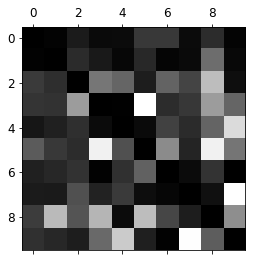

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Agora podemos ver claramente os tipos de erros que o classificador faz. 

Lembrando que as linhas representam classes reais, enquanto as colunas representam as classes previstas. 

As colunas das classes 8 e 9 são bastante claras, o que indica que muitas imagens são classificadas erroneamente como 8s ou 9s. 

Da mesma forma, as linhas das classes 8 e 9 também são bastante brilhantes, informando que 8s e 9s são frequentemente confundidos com outros dígitos. 

Por outro lado, algumas linhas são muito escuras, como a linha 1: isso significa que a maioria dos 1s é classificada corretamente (alguns são confundidos com 8s, mas isso é tudo). 

Observe que os erros não são perfeitamente simétricos; Por exemplo, há mais 5s incorretamente classificados como 8s do que o inverso. 

Analisar a matriz de confusão muitas vezes pode fornecer informações sobre maneiras de melhorar seu classificador.

Olhando para estes resultados, parece que os nossos esforços devem ser gastos na melhoria da classificação de 8s e 9s, bem como corrigir a confusão específica de 3 e 5. 

Por exemplo, podemos tentar reunir mais dados de treinamento para esses dígitos. 

Ou você poderia criar novos recursos que ajudariam o classificador - por exemplo, escrever um algoritmo para contar o número de loops fechados (por exemplo, 8 tem dois, 6 tem um, 5 não tem nenhum). Ou você poderia pré-processar as imagens (por exemplo, usando Scikit-Image, Pillow ou OpenCV) para destacar alguns padrões, como loops fechados.

A análise de erros individuais também pode ser uma boa maneira de obter insights sobre o que seu classificador está fazendo e por que está falhando, mas é mais difícil e demorado. 

Por exemplo, vamos traçar exemplos de 3s e 5s:

Saving figure error_analysis_digits_plot


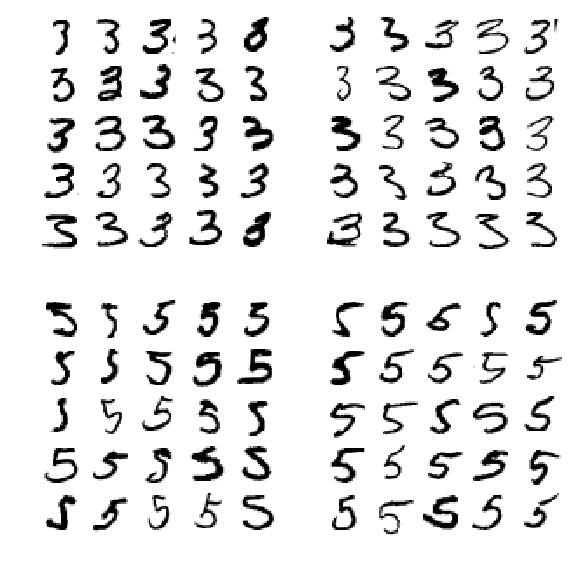

In [0]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Os dois blocos 5 × 5 à esquerda mostram dígitos classificados como 3s e os dois blocos 5 × 5 à direita mostram imagens classificadas como 5s. 

Alguns dos dígitos que o classificador erra (ou seja, nos blocos inferior esquerdo e superior direito) são tão mal escritos que até um ser humano teria dificuldade em classificá-los (por exemplo, os 5 na 8ª linha e na 1ª coluna realmente parecem como um 3). 

No entanto, a maioria das imagens equivocadas parece ser um erro óbvio para nós, e é difícil entender por que o classificador cometeu os erros cometidos. 

O motivo é que usamos um `SGDClassifier` simples, que é um modelo linear. Tudo o que faz é atribuir um peso por classe a cada pixel e, quando vê uma nova imagem, resume as intensidades de pixels ponderadas para obter uma pontuação para cada classe. 

Então, como 3s e 5s diferem apenas por alguns pixels, esse modelo irá facilmente confundi-los.

A principal diferença entre 3s e 5s é a posição da pequena linha que une a linha superior ao arco inferior. 

Se você desenhar um 3 com a junção levemente deslocada para a esquerda, o classificador poderá classificá-lo como 5 e vice-versa. 

Em outras palavras, esse classificador é bastante sensível à mudança e rotação de imagens. 

Portanto, uma maneira de reduzir a confusão 3/5 seria pré-processar as imagens para garantir que elas sejam bem centralizadas e não giradas demais. 

Isso provavelmente ajudará a reduzir outros erros também.

# Classificação Multilabel

Até agora, cada instância sempre foi atribuída a apenas uma classe. Em alguns casos você pode querer que seu classificador envie várias classes para cada instância. 

Por exemplo, considere um classificador de reconhecimento de rosto: o que ele deve fazer se reconhecer várias pessoas na mesma imagem? Claro que deve anexar um rótulo por pessoa que reconhece. 

Digamos que o classificador tenha sido treinado para reconhecer três rostos, Ana, Rogerio e Carlos; então quando é mostrada uma foto de Ana e Carlos, deve sair [1, 0, 1] (significando “Ana sim, Rogerio não, Carlos sim”). 

Tal sistema de classificação que gera múltiplos rótulos binários é chamado de sistema de classificação multi-rótulo.

Ainda não vamos ao reconhecimento facial, mas vamos ver um exemplo mais simples, apenas como prova de conceito:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Esse código cria um array y_multilabel contendo dois labels de destino para cada imagem de dígito: a primeira indica se o dígito é grande ou não (7, 8 ou 9) e a segunda indica se é ou não ímpar. 

As próximas linhas criam uma instância do `KNeighborsClassifier` (que suporta classificação multilabel, mas nem todos os classificadores suportam) e nós a treinamos usando o array de múltiplos alvos. 

Agora você pode fazer uma previsão e perceber que ela gera dois rótulos:

In [0]:
knn_clf.predict([some_digit])

array([[False,  True]])

E como podemos ver, o dígito 5 não é de fato grande (False) e ímpar (True). 

Há muitas maneiras de avaliar um classificador de vários rótulos, e selecionar a métrica correta realmente depende do seu projeto. 

Por exemplo, uma abordagem é medir a pontuação F1 para cada rótulo individual (ou qualquer outra métrica de classificação binária discutida anteriormente) e, em seguida, simplesmente calcular a pontuação média. 

Esse código calcula a pontuação média da F1 em todos os rótulos:

**Atenção**: a seguinte célula pode demorar muito tempo (possivelmente horas dependendo do seu hardware).

In [0]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

Isso pressupõe que todos os rótulos são igualmente importantes, o que pode não ser o caso. 

Em particular, se você tiver mais fotos de Ana do que do Rogerio ou do Carlos, talvez queira dar mais peso à pontuação do classificador nas fotos de Ana. 
Uma opção simples é dar a cada label um peso igual ao seu suporte (ou seja, o número de instâncias com esse label alvo). 

Para fazer isso, basta definir `average = "weighted"` no código anterior

## Classificação Multioutput

O último tipo de tarefa de classificação que vamos discutir aqui é chamado classificação multioutput-multiclass (ou simplesmente classificação multioutput). É simplesmente uma generalização da classificação multilabel, onde cada etiqueta pode ser multiclasse (isto é, pode ter mais de dois valores possíveis).

Para ilustrar isso, vamos criar um sistema que remova o ruído das imagens. Ele terá como entrada uma imagem com dígitos ruidosos, e produzirá (se tudo der certo) uma imagem com dígitos limpos, representada como uma matriz de intensidades de pixel, assim como as imagens MNIST. 

Observe que a saída do classificador é multilabel (um rótulo por pixel) e cada rótulo pode ter vários valores (intervalos de intensidade de pixel de 0 a 255).

É, portanto, um exemplo de um sistema de classificação de múltiplas saídas.

**NOTA:** A linha entre classificação e regressão é às vezes embaçada, como neste exemplo. Indiscutivelmente, a previsão da intensidade do pixel é mais semelhante à regressão do que à classificação. Além disso, os sistemas de múltiplas saídas não se limitam a tarefas de classificação; Você pode até ter um sistema que produza vários rótulos por instância, incluindo rótulos de classe e rótulos de valor.

Vamos começar criando os conjuntos de treinamento e teste pegando as imagens MNIST e adicionando ruído às suas intensidades de pixel usando a função `randint()` do NumPy. As imagens de destino serão as imagens originais:

In [0]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Vamos dar uma olhada em uma imagem do conjunto de testes:

In [0]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

À esquerda está a imagem de entrada ruidosa e à direita está a imagem alvo limpa. Agora vamos treinar o classificador e torná-lo limpo esta imagem:

In [0]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Parece perto o suficiente do que queriamos!

## Classificador Dummy (aleatório)

In [0]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

In [0]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Classificador KNN 

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

In [0]:
y_knn_pred = knn_clf.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

In [0]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [0]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [0]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [0]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [0]:
accuracy_score(y_test, y_knn_expanded_pred)

In [0]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [0]:
plot_digit(ambiguous_digit)